In [1]:
import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-koaki7h2 because the default path (/home/nas4_user/yeojeongpark/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


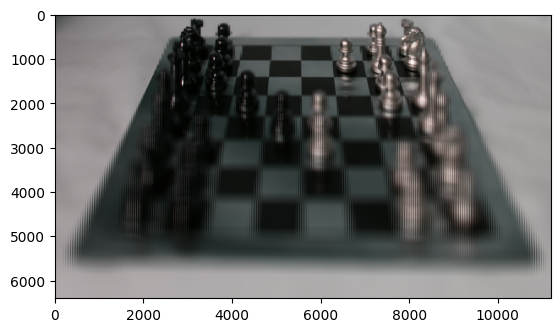

In [2]:
img_path = 'data/chessboard_lightfield.png'
img = cv2.imread(img_path)
plt.imshow(img)

## Initials

In [3]:
h,w,c = img.shape
u = 16
v = 16
s = h // u # 400
t = w // v # 700


In [4]:
L = np.zeros((u,v,s,t,c), dtype=np.uint8)
for ch in range(c):
    for i in range(s):
        for j in range(t):
            for k in range(u):
                for l in range(v):
                    L[k,l,i,j,ch] = img[u*i+k, v*j+l, ch]

In [5]:
L.shape

(16, 16, 400, 700, 3)

## Sub-aperture views

In [20]:
mosaic_img = np.zeros((u*s, v*t, c), dtype=np.uint8)
for i in range(u):
    for j in range(v):
        mosaic_img[i*s:i*s + s, j*t:j*t + t, :] = L[i,j,...]

cv2.imwrite("mosaic_img.png", mosaic_img)

True

## Refocusing and focal-stack generation

In [440]:
def refocus(alpha, L_array):
    lensletSize = 16
    maxUV = lensletSize // 2
    stack_img = np.zeros((s,t,c), dtype=np.float32)
    d = 1 - 1/alpha
    print(f"d : {d}")
    for i in range(s):
        for j in range(t):
            count = 0
            for k in range(u):
                u_ = k - maxUV
                i_idx = i + math.ceil(d*u_)
                for l in range(v):
                    v_ = l - maxUV
                    j_idx = j - math.ceil(d*v_) #                                                                                                                                                                                                  bc the image is flipped
                    if i_idx >= 0 and i_idx < s and j_idx >= 0 and j_idx < t:
                        u_idx = int(u_ + maxUV)
                        v_idx = int(v_ + maxUV)
                        stack_img[i,j,:] += L_array[u_idx, v_idx, i_idx, j_idx, :]
                        count += 1
            stack_img[i,j,:] /= count
    file_name = f"refocus_{alpha}.png"
    cv2.imwrite(file_name, stack_img) 
    print(f"saved {file_name}")

In [448]:
refocus(alpha=1, L_array=L) # d=0.0
refocus(alpha=1.5, L_array=L) # d=0.3
refocus(alpha=2.5, L_array=L) # d=0.6

d : 0.0
saved refocus_1.png
d : 0.33333333333333337
saved refocus_1.5.png
d : 0.6
saved refocus_2.5.png


In [449]:
refocus(alpha=10, L_array=L) # d=0.9
refocus(alpha=-5, L_array=L) # d=1.2
refocus(alpha=-2, L_array=L) # d=1.5

d : 0.9
saved refocus_10.png
d : 1.2
saved refocus_-5.png
d : 1.5
saved refocus_-2.png


## All-focus image and depth from defocus

In [455]:
def XYZ_to_RGB_linear(rgb_space='sRGB'):
    """ Data from

    http://brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html

    Name             Gamma   Reference White   Red Primary            Green Primary          Blue Primary        Volume (deltaE^3)         Lab Gamut Efficiency  Coding Efficiency
                                              x      y      Y        x      y      Y        x      y      Y
    Lab Gamut          -         D50           -      -      -        -      -      -        -      -      -        2,381,085                   97.0              35.1
    Adobe RGB (1998) 2.2         D65           0.6400 0.3300 0.297361 0.2100 0.7100 0.627355 0.1500 0.0600 0.075285 1,208,631                   50.6             100.0
    Apple RGB        1.8         D65           0.6250 0.3400 0.244634 0.2800 0.5950 0.672034 0.1550 0.0700 0.083332   798,403                   33.5             100.0
    Best RGB         2.2         D50           0.7347 0.2653 0.228457 0.2150 0.7750 0.737352 0.1300 0.0350 0.034191 2,050,725                   77.6              96.5
    Beta RGB         2.2         D50           0.6888 0.3112 0.303273 0.1986 0.7551 0.663786 0.1265 0.0352 0.032941 1,717,450                   69.3              99.0
    Bruce RGB        2.2         D65           0.6400 0.3300 0.240995 0.2800 0.6500 0.683554 0.1500 0.0600 0.075452   988,939                   41.5             100.0
    CIE RGB          2.2         E             0.7350 0.2650 0.176204 0.2740 0.7170 0.812985 0.1670 0.0090 0.010811 1,725,261                   64.3              96.1
    ColorMatch RGB   1.8         D50           0.6300 0.3400 0.274884 0.2950 0.6050 0.658132 0.1500 0.0750 0.066985   836,975                   35.2             100.0
    Don RGB 4        2.2         D50           0.6960 0.3000 0.278350 0.2150 0.7650 0.687970 0.1300 0.0350 0.033680 1,802,358                   72.1              98.8
    ECI RGB v2        L*         D50           0.6700 0.3300 0.320250 0.2100 0.7100 0.602071 0.1400 0.0800 0.077679 1,331,362                   55.3              99.7
    Ekta Space PS5   2.2         D50           0.6950 0.3050 0.260629 0.2600 0.7000 0.734946 0.1100 0.0050 0.004425 1,623,899                   65.7              99.5
    NTSC RGB         2.2         C             0.6700 0.3300 0.298839 0.2100 0.7100 0.586811 0.1400 0.0800 0.114350 1,300,252                   54.2              99.9
    PAL/SECAM RGB    2.2         D65           0.6400 0.3300 0.222021 0.2900 0.6000 0.706645 0.1500 0.0600 0.071334   849,831                   35.7             100.0
    ProPhoto RGB     1.8         D50           0.7347 0.2653 0.288040 0.1596 0.8404 0.711874 0.0366 0.0001 0.000086 2,879,568                   91.2              87.3
    SMPTE-C RGB      2.2         D65           0.6300 0.3400 0.212395 0.3100 0.5950 0.701049 0.1550 0.0700 0.086556   758,857                   31.9             100.0
    sRGB            #2.2         D65           0.6400 0.3300 0.212656 0.3000 0.6000 0.715158 0.1500 0.0600 0.072186   832,870                   35.0             100.0
    Wide Gamut RGB   2.2         D50           0.7350 0.2650 0.258187 0.1150 0.8260 0.724938 0.1570 0.0180 0.016875 2,164,221                   77.6              91.9


    #2.2 - actual transform is more complex (see http://brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html )

    deltaE^3 is the volume of the gamut in Lab space
    Coding efficiency is the amount of the gamut inside the horseshoe diagram

    implementation verified with Bruce Lindbloom's data
    """

    color_spaces = [ 'Adobe RGB (1998)', 'Apple RGB', 'Best RGB', 'Beta RGB', 'Bruce RGB','CIE RGB', \
                     'ColorMatch RGB','Don RGB 4','ECI RGB v2','Ekta Space PS5','NTSC RGB','PAL/SECAM RGB','ProPhoto RGB','SMPTE-C RGB','sRGB','Wide Gamut RGB']


    reference_whites = [ 'D65', 'D65','D50','D50','D65','E','D50','D50','D50','D50','C','D65','D50','D65','D65','D50' ]

    xyY_red = np.array([[ 0.6400, 0.3300, 0.297361], \
                         [0.6250, 0.3400, 0.244634], \
                         [0.7347, 0.2653, 0.228457], \
                         [0.6888, 0.3112, 0.303273], \
                         [0.6400, 0.3300, 0.240995], \
                         [0.7350, 0.2650, 0.176204], \
                         [0.6300, 0.3400, 0.274884], \
                         [0.6960, 0.3000, 0.278350], \
                         [0.6700, 0.3300, 0.320250], \
                         [0.6950, 0.3050, 0.260629], \
                         [0.6700, 0.3300, 0.298839], \
                         [0.6400, 0.3300, 0.222021], \
                         [0.7347, 0.2653, 0.288040], \
                         [0.6300, 0.3400, 0.212395], \
                         [0.6400, 0.3300, 0.212656], \
                         [0.7350, 0.2650, 0.258187]])

    xyY_green = np.array([[0.2100, 0.7100, 0.627355], \
                          [0.2800, 0.5950, 0.672034], \
                          [0.2150, 0.7750, 0.737352], \
                          [0.1986, 0.7551, 0.663786], \
                          [0.2800, 0.6500, 0.683554], \
                          [0.2740, 0.7170, 0.812985], \
                          [0.2950, 0.6050, 0.658132], \
                          [0.2150, 0.7650, 0.687970], \
                          [0.2100, 0.7100, 0.602071], \
                          [0.2600, 0.7000, 0.734946], \
                          [0.2100, 0.7100, 0.586811], \
                          [0.2900, 0.6000, 0.706645], \
                          [0.1596, 0.8404, 0.711874], \
                          [0.3100, 0.5950, 0.701049], \
                          [0.3000, 0.6000, 0.715158], \
                          [0.1150, 0.8260, 0.724938]])

    xyY_blue = np.array([[0.1500, 0.0600, 0.075285], \
                         [0.1550, 0.0700, 0.083332], \
                         [0.1300, 0.0350, 0.034191], \
                         [0.1265, 0.0352, 0.032941], \
                         [0.1500, 0.0600, 0.075452], \
                         [0.1670, 0.0090, 0.010811], \
                         [0.1500, 0.0750, 0.066985], \
                         [0.1300, 0.0350, 0.033680], \
                         [0.1400, 0.0800, 0.077679], \
                         [0.1100, 0.0050, 0.004425], \
                         [0.1400, 0.0800, 0.114350], \
                         [0.1500, 0.0600, 0.071334], \
                         [0.0366, 0.0001, 0.000086], \
                         [0.1550, 0.0700, 0.086556], \
                         [0.1500, 0.0600, 0.072186], \
                         [0.1570, 0.0180, 0.016875 ]])


    for i in range(len(color_spaces)):
        if color_spaces[i] == rgb_space:            
            index_row = i

    Xr, Yr, Zr = xyY_to_XYZ( xyY_red[index_row, 0], xyY_red[index_row, 1], xyY_red[index_row, 2] )
    Xg, Yg, Zg = xyY_to_XYZ( xyY_green[index_row, 0], xyY_green[index_row, 1], xyY_green[index_row, 2] )
    Xb, Yb, Zb = xyY_to_XYZ( xyY_blue[index_row, 0], xyY_blue[index_row, 1], xyY_blue[index_row, 2] )


    illuminant = reference_whites[index_row]

    Xw, Yw, Zw = illuminant_xyz(illuminant)

    S = np.linalg.inv( np.array([[Xr, Xg, Xb], [Yr, Yg, Yb], [Zr, Zg, Zb]]) ) @ np.array([Xw, Yw, Zw])

    # this matrix is RGB to XYZ
    M = np.array([ [S[0]*Xr, S[1]*Xg, S[2]*Xb], [S[0]*Yr, S[1]*Yg, S[2]*Yb], [S[0]*Zr, S[1]*Zg, S[2]*Zb]])

    M = np.linalg.inv(M)

    return M, illuminant 

def illuminant_xyz(illuminant_in):
    """(c) Ivo Ihrke 2011
     Universitaet des Saarlandes / MPI Informatik

    define xyz coordinates of CIE standard illuminants
    1931 and 1964

    data from 

    http://en.wikipedia.org/wiki/Standard_illuminant



    Name    CIE 1931 2°    CIE 1964 10° CCT (*) in K    Hue Note
        x2       y2     x10     y10
    A   0.44757, 0.40745, 0.45117, 0.40594, 2856            Incandescent / Tungsten
    B   0.34842, 0.35161, 0.34980, 0.35270, 4874            {obsolete} Direct sunlightat noon
    C   0.31006, 0.31616, 0.31039, 0.31905, 6774            {obsolete} Average / North sky Daylight
    D50 0.34567, 0.35850, 0.34773, 0.35952, 5003            Horizon Light. ICC profile PCS
    D55 0.33242, 0.34743, 0.33411, 0.34877, 5503            Mid-morning / Mid-afternoon Daylight
    D65 0.31271, 0.32902, 0.31382, 0.33100, 6504            Noon Daylight: Television, sRGB color space
    D75 0.29902, 0.31485, 0.29968, 0.31740, 7504            North sky Daylight
    E   1/3    , 1/3    , 1/3    , 1/3    , 5454            Equal energy
    F1  0.31310, 0.33727, 0.31811, 0.33559, 6430            Daylight Fluorescent
    F2  0.37208, 0.37529, 0.37925, 0.36733, 4230            Cool White Fluorescent
    F3  0.40910, 0.39430, 0.41761, 0.38324, 3450            White Fluorescent
    F4  0.44018, 0.40329, 0.44920, 0.39074, 2940            Warm White Fluorescent
    F5  0.31379, 0.34531, 0.31975, 0.34246, 6350            Daylight Fluorescent
    F6  0.37790, 0.38835, 0.38660, 0.37847, 4150            Lite White Fluorescent
    F7  0.31292, 0.32933, 0.31569, 0.32960, 6500            D65 simulator, Daylight simulator
    F8  0.34588, 0.35875, 0.34902, 0.35939, 5000            D50 simulator, Sylvania F40 Design 50
    F9  0.37417, 0.37281, 0.37829, 0.37045, 4150            Cool White Deluxe Fluorescent
    F10 0.34609, 0.35986, 0.35090, 0.35444, 5000            Philips TL85, Ultralume 50
    F11 0.38052, 0.37713, 0.38541, 0.37123, 4000            Philips TL84, Ultralume 40
    F12 0.43695, 0.40441, 0.44256, 0.39717, 3000            Philips TL83, Ultralume 30

    (*) CCT= correlated color temperature


    standard is the 1931 definition

    illuinant_in = 'A','B','C', 'D50','D55','D65','D75' etc.

    for 1964 version use 

    illuinant_in = 'A_64','B_64','C_64', 'D50_64','D55_64','D65_64','D75_64' etc.


    verification performed by checking 

    http://brucelindbloom.com/index.html?Eqn_ChromAdapt.html

    """


    ind1931 = np.arange(0, 2)
    ind1964 = np.arange(2, 4)

    illuminants = [ 'A', 'B', 'C', 'D50', 'D55','D65','D75','E','F1', \
                    'F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F11']


    xy = np.array([[0.44757, 0.40745, 0.45117, 0.40594], \
          [0.34842, 0.35161, 0.34980, 0.35270], \
          [0.31006, 0.31616, 0.31039, 0.31905], \
          [0.34567, 0.35850, 0.34773, 0.35952], \
          [0.33242, 0.34743, 0.33411, 0.34877], \
          [0.31271, 0.32902, 0.31382, 0.33100], \
          [0.29902, 0.31485, 0.29968, 0.31740], \
          [1/3    , 1/3    , 1/3    , 1/3    ], \
          [0.31310, 0.33727, 0.31811, 0.33559], \
          [0.37208, 0.37529, 0.37925, 0.36733], \
          [0.40910, 0.39430, 0.41761, 0.38324], \
          [0.44018, 0.40329, 0.44920, 0.39074], \
          [0.31379, 0.34531, 0.31975, 0.34246], \
          [0.37790, 0.38835, 0.38660, 0.37847], \
          [0.31292, 0.32933, 0.31569, 0.32960], \
          [0.34588, 0.35875, 0.34902, 0.35939], \
          [0.37417, 0.37281, 0.37829, 0.37045], \
          [0.34609, 0.35986, 0.35090, 0.35444], \
          [0.38052, 0.37713, 0.38541, 0.37123], \
          [0.43695, 0.40441, 0.44256, 0.39717]])
          
    for i in range(len(illuminants)):
        if illuminants[i] == illuminant_in:
            index_row = i
            index_cols = ind1931

            if len(illuminant_in) > 3:
                if illuminant_in[-3:] == '_64':
                    index_cols = ind1964

            
            data = xy[index_row, index_cols]
            
            X, Y, Z = xyY_to_XYZ(data[0], data[1], 1)
            
    return X, Y, Z

def lRGB2XYZ(lRGB):
    """ linear RGB to XYZ
    """
    invM = XYZ_to_RGB_linear('sRGB')[0]
    M = np.linalg.inv(invM)

    # linear rgb
    R = lRGB[:,:,0]
    G = lRGB[:,:,1]
    B = lRGB[:,:,2]

    # through matrix to XYZ
    X = M[0,0] * R + M[0,1] * G + M[0,2] * B
    Y = M[1,0] * R + M[1,1] * G + M[1,2] * B
    Z = M[2,0] * R + M[2,1] * G + M[2,2] * B
    
    XYZ = np.dstack((X, Y, Z))
    return XYZ

def xyY_to_XYZ(x, y, Y):
    """(c) Ivo Ihrke 2011
    Universitaet des Saarlandes / MPI Informatik
    """

    Xo = Y * x / y
    Yo = Y
    Zo = Y * ( 1 - x - y ) / y
    return Xo, Yo, Zo

def XYZ2xyY(img):
    X,Y,Z = img[...,0], img[...,1], img[...,2]
    x = X / (X+Y+Z)
    y = Y / (X+Y+Z)
    xyY = np.dstack([x,y,Y])
    return xyY

In [494]:
sigma1 = 0.5
sigma2 = 0.5
img_list = ['refocus_1.png', 'refocus_1.5.png', 'refocus_2.5.png', 'refocus_10.png', 
            'refocus_-5.png', 'refocus_-2.png',]
d = np.arange(0.0, 1.6, 0.3)
weight_list = []
for img_path in img_list:
    img = cv2.imread(img_path)
    xyY_img = XYZ2xyY(lRGB2XYZ(img)) # convert RGB to XYZ, XYZ to xyY
    I_lumi = xyY_img[:,:,2] # extract the luminance channel
    I_low = cv2.GaussianBlur(I_lumi, (0, 0), sigma1) # compute a low freq. component
    I_high = I_lumi - I_low # compute a high freq. component
    w_sharp = cv2.GaussianBlur(I_high * I_high, (0, 0), sigma2) # compute the sharpness weight
    weight_list.append(w_sharp)


In [496]:
all_focus = np.zeros((s,t,c))
depth_map = np.zeros((s,t))
sum_w = sum(weight_list)
for i, (img_path, w) in enumerate(zip(img_list, weight_list)):
    img = cv2.imread(img_path)
    all_focus += w[..., np.newaxis] * img
    depth_map += w * d[i]
all_focus /= sum_w[..., np.newaxis]
depth_map /= sum_w

In [497]:
cv2.imwrite("all_focus.png", all_focus)
cv2.imwrite("depth_map.png", depth_map*255)

True